In [251]:
#function：曲线生成
import numpy as np
import math
import bisect

class Spline:
    u"""
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        u"""
        Calc position
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        u"""
        Calc first derivative
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        u"""
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        u"""
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        u"""
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        u"""
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        #  print(B)
        return B


class Spline2D:
    u"""
    2D Cubic Spline class
    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = [math.sqrt(idx ** 2 + idy ** 2)
                   for (idx, idy) in zip(dx, dy)]
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        u"""
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        u"""
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / (dx ** 2 + dy ** 2)
        return k

    def calc_yaw(self, s):
        u"""
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s

In [282]:
#function：曲线坐标/直角坐标相互转换
from scipy.spatial.distance import pdist
import math
import numpy as np

#曲线给定，输入(x,y),输出(s,v)，以v绝对值最小为原则。
def xy2curv(point,curv):
    #求坐标的函数，首先根据最小距离得到s坐标和v坐标的绝对值
    distances=[]
    rrs = [i[0] for i in curv]
    rrx = [i[1] for i in curv]
    rry = [i[2] for i in curv]
    for i in range(len(curv)):
        X = np.vstack([point,[rrx[i],rry[i]]])
        distances.append(pdist(X)[0])
    fs = distances.index(min(distances))
    vertical = min(distances)

    #判断vertical正负，根据s坐标计算出法向量
    dxdy = [rrx[fs+1]-rrx[fs],rry[fs+1]-rry[fs]]
    #先把求到的dxdy求单位值
    norm = 0
    for i in range(len(dxdy)):
        norm +=dxdy[i]**2
    for i in range(len(dxdy)):
        dxdy[i] = dxdy[i]/math.sqrt(norm)

    #求dxdy法向量
    vert = [-dxdy[1],dxdy[0]]#沿s行走逆时针为正 - 这个是法向量

    #和法向量求数量积
    lxly = [point[0]-rrx[fs],point[1]-rry[fs]]
    quad = lxly[0]*vert[0]+lxly[1]*vert[1]
    #根据数量积的正负值，判断v的正负
    if quad >=0:
        vertical = vertical
    else:
        vertical = -vertical
        
    return [rrs[fs],vertical,fs]

    #然后根据距离计算出正负点
    #disver = [i*vertical for i in posdxdy]
    #pointpos = [rx[fs]+dispos[0],ry[fs]+dispos[1]]

#曲线给定，输入（s,v）输出（x,y），在任意赋值时，可能会有多组（s，v）对应到同一个（x,y）
def curv2xy(point,curv):
    s = point[0]
    if s == None:
        return None
    v = point[1]
    if v == None:
        return None
    
    rrs = [i[0] for i in curv]
    rrx = [i[1] for i in curv]
    rry = [i[2] for i in curv]
    #首先根据输入的s值找到他在曲线中对应的字典位置
    rrsd = [(i[0]-s)**2 for i in curv]
    if s<rrs[0]:
        return None
    elif s>rrs[-1]:
        return None
    fs = rrsd.index(min(rrsd))
    
    #然后求出法向量
    dxdy = [rrx[fs+1]-rrx[fs],rry[fs+1]-rry[fs]]
    #先把求到的dxdy求单位值
    norm = 0
    for i in range(len(dxdy)):
        norm +=dxdy[i]**2
    for i in range(len(dxdy)):
        dxdy[i] = dxdy[i]/math.sqrt(norm)
    vert = [-dxdy[1],dxdy[0]] #法向量
    
    #根据法向量求出距离
    disvert = [i*v for i in vert]
    x = rrx[fs]+disvert[0]
    y = rry[fs]+disvert[1]
    return [x,y]


In [283]:
#function:轨迹相关的曲线绘制
class Spline2Points:
    u"""
    compute spline with 2 points and their derivatives.
    """

    def __init__(self, point1, point2,theta):
        s1=point1[0]
        s2=point2[0]
        v1=point1[1]
        v2=point2[1]
        self.x = [s1,s2]
        self.y = [v1,v2]

        MatA=np.array([[1,s1,s1**2,s1**3],[1,s2,s2**2,s2**3],[0,1,2*s1,3*s1**2],[0,1,2*s2,3*s2**2]])
        MatB=np.array([[0],[v2-v1],[math.tan(theta)],[0]])
        paras = np.linalg.solve(MatA,MatB)
        self.paras = paras
        self.a = paras[0][0]
        self.b = paras[1][0]
        self.c = paras[2][0]
        self.d = paras[3][0]

    def calc(self, t):
        u"""
        Calc position
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]+10:
            return None

        if self.x[-1]<t<=self.x[-1]+10:
            result = self.y[1]
        else:
            i = self.__search_index(t)
            #dx = t - self.x[0]
            dx=t
            result = self.a + self.b * dx + \
                self.c * dx ** 2.0 + self.d * dx ** 3.0 + self.y[0]

        return result

    def calcd(self, t):
        u"""
        Calc first derivative
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]+10:
            return None

        if self.x[-1]<t<=self.x[-1]+10:
            result = 0
        else:
            i = self.__search_index(t)
            dx=t
            #dx = t - self.x[0]
            result = self.b + 2.0 * self.c * dx + 3.0 * self.d * dx ** 2.0
        return result

    def calcdd(self, t):
        u"""
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]+10:
            return None

        if self.x[-1]<t<=self.x[-1]+10:
            result = 0
        else:
            i = self.__search_index(t)
            dx=t
            #dx = t - self.x[0]
            result = 2.0 * self.c + 6.0 * self.d * dx
        return result

    def __search_index(self, x):
        u"""
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1


In [340]:
#定义障碍物，判断点是否在障碍物内

def GetDot(p1,p2,p):
    return (p2[0]-p1[0])*(p[0]-p1[0])+(p2[1]-p1[1])*(p[1]-p1[1])
def GetCross(p1,p2,p):
    return (p2[0]-p1[0])*(p[1]-p1[1])-(p[0]-p1[0])*(p2[1]-p1[1])
def distance(p1,p2):
    return math.sqrt((p2[1]-p1[1])**2+(p2[0]-p1[0])**2)
class obstacle:
    def __init__(self,point1,point2,point3): #左上 右上 左下
        self.point1=point1
        self.point2=point2
        self.point3=point3
        self.point4=[point2[0]+point3[0]-point1[0],point3[1]+point2[1]-point1[1]]
        self.center=[(point2[0]+point3[0])/2,(point3[1]+point2[1])/2]
        point4 = self.point4
        
        self.edge1 = [point2[0]-point1[0],point2[1]-point1[1]]
        self.edge2 = [point3[0]-point1[0],point3[1]-point1[1]]
        self.edge3 = [point4[0]-point3[0],point4[1]-point3[1]]
        self.edge4 = [point4[0]-point2[0],point4[1]-point2[1]]
    def inside(self,p):#判断一个外部点是不是在矩形里面
        return GetDot(self.point3,self.point1,p)>=0 and GetDot(self.point3,self.point4,p) >= 0 and GetDot(self.point2,self.point4,p) >=0 and GetDot(self.point2,self.point1,p) >= 0
        
        

In [341]:
ob=obstacle([5,3],[5,5],[4,2])
testp=[4,6]
distance([0,0],[3,4])

5.0

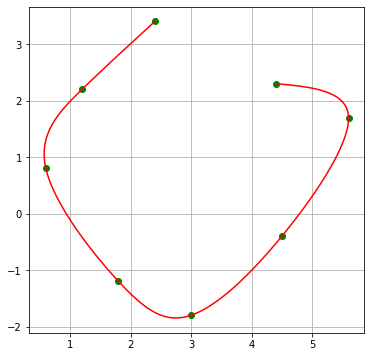

In [303]:
#测试：绘制三次样条曲线y=f(s),x=g(s)
import sys
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
s = [-4,0,4,8,12,16,20,24];
x = [2.4,1.2,0.6,1.8,3,4.5,5.6,4.4];
y = [3.4,2.2,0.8,-1.2,-1.8,-0.4,1.7,2.3]
spline = Spline(s,x)
spline2 = Spline(s,y)
rs = np.arange(-4,30,0.01)
rx = [spline.calc(i) for i in rs]
ry = [spline2.calc(i) for i in rs]
plt.xlim = (0,7)
plt.ylim = (-3,4)
plt.plot(x,y,"og")
plt.plot(rx,ry,"-r")
plt.grid(True)
plt.show()

[-1.040000000000063, -1.4088773888278436, 296]


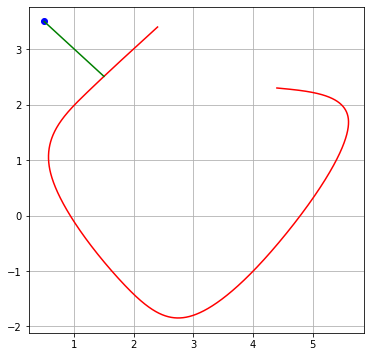

In [306]:
#xy转曲线测试
curv = []
for i in range(len(rs)):
    curv.append([rs[i],rx[i],ry[i]])
point = [0.5,3.5]
pointcurv = xy2curv(point,curv)
fs = pointcurv[2]
vertical = pointcurv[1]
ppx = [point[0],rx[fs]]
ppy = [point[1],ry[fs]]

plt.plot(point[0],point[1],"ob")
plt.plot(rx,ry,"-r")

if vertical>=0:
    plt.plot(ppx,ppy,"-b")
else:
    plt.plot(ppx,ppy,"-g")

#plt.plot(ppxpos,ppypos,"-g")
#plt.plot(ppxneg,ppyneg,"-y")
print(pointcurv)

plt.show()

[3.705569335868929, 0.20735485499686612]


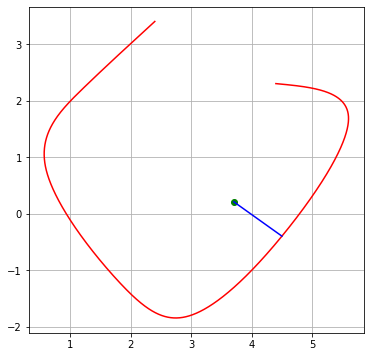

In [310]:
#曲线转xy测试，曲线给定
curv = []
for i in range(len(rs)):
    curv.append([rs[i],rx[i],ry[i]])
point = [16,1.0]
pointxy = curv2xy(point,curv)
ppsd = [(i[0]-point[0])**2 for i in curv]
ps = ppsd.index(min(ppsd))

ppx = [pointxy[0],rx[ps]]
ppy = [pointxy[1],ry[ps]]
plt.figure(figsize=(6,6))
plt.grid(True)
plt.plot(pointxy[0],pointxy[1],"og")
plt.plot(rx,ry,"-r")
if point[1]>=0:
    plt.plot(ppx,ppy,"-b")
else:
    plt.plot(ppx,ppy,"-g")

#plt.plot(ppxpos,ppypos,"-g")
#plt.plot(ppxneg,ppyneg,"-y")
print(pointxy)

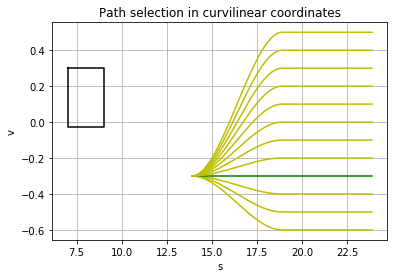

In [401]:
#轨迹生成测试
#设定v的范围（基本含义是路的宽度）
vmin = -0.6
vmax = 0.6
vrange = np.arange(vmin,vmax,0.1)

#下面这些列表是存变量用的
traces=[]
tracess=[]
tracesv=[]
blockornot=[]
curvs=[]

#创建一个障碍物
p1=[7,0.3]
p2=[9,0.3]
p3=[7,-0.03]
blocker = obstacle(p1,p2,p3)
blockerx=[blocker.point1[0],blocker.point2[0],blocker.point4[0],blocker.point3[0],blocker.point1[0]]
blockery=[blocker.point1[1],blocker.point2[1],blocker.point4[1],blocker.point3[1],blocker.point1[1]]

#创建一个车辆
point1=[13.9,-0.3]

for i in vrange:
    point2=(point1[0]+5,i)
    theta = 0
    s2 = [point1[0],point2[0]]
    v2 = [point1[1],point2[1]]
    
    #首先生成轨迹
    splineq = Spline2Points(point1,point2,theta)
    splines.append(splineq)
    rs3 = np.arange(point1[0],point1[0]+10,0.01)
    rv3 = [splineq.calc(i) for i in rs3]
    tracess.append(rs3)
    tracesv.append(rv3)
    blocked=0
    
    #然后判定轨迹是否被挡
    for j in range(len(rs3)):
        pointtst=[rs3[j],rv3[j]]
        if blocker.inside(pointtst):
            blocked=1
    blockornot.append(blocked)
    
    #然后算轨迹总长度/s变化量
    points2 = []
    distancetotal=0
    for j in range(len(rs3)):
        point = [rs3[j],rv3[j]]
        points2.append(point)
        if j!=0:
            distancetotal += distance(points2[j],points2[j-1])
    curvvalue = distancetotal/(rs3[-1]-rs3[0])
    curvs.append(curvvalue)
        
    trace = {'id':i,'s':rs3,'v':rv3,'status':blocked,'valeur':curvvalue}
    traces.append(trace)

curvsforchoice = curvs
for i in range(len(traces)):
    if blockornot[i]==1:
        curvsforchoice[i]+=max(curvsforchoice)
idchosen = curvsforchoice.index(min(curvsforchoice))
traces[idchosen]['status']=2
blockornot[idchosen]=2

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
for trace in traces:
    if trace['status'] == 1:
        ax1.plot(trace['s'],trace['v'],"-r")
    elif trace['status'] == 0:
        ax1.plot(trace['s'],trace['v'],"-y") 
    else:
        ax1.plot(trace['s'],trace['v'],"-g")
    ax1.grid(True)

ax1.set_title("Path selection in curvilinear coordinates")
ax1.plot(blockerx,blockery,"-k")
ax1.set_xlabel("s")
ax1.set_ylabel("v")
plt.show()



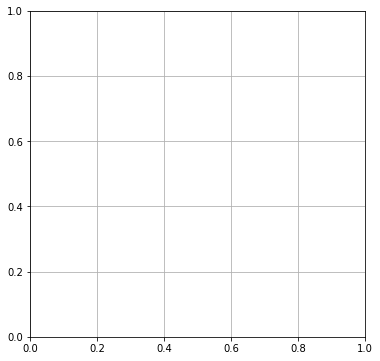

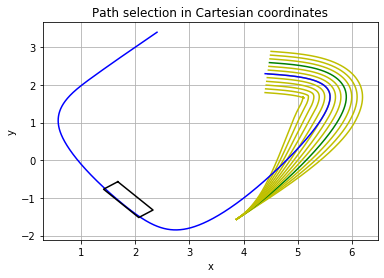

In [402]:
#测试，将上一个板块生成的轨迹投影在x，y平面上
curv = []
rx2list=[]
ry2list=[]
plt.figure(figsize=(6,6))
plt.grid(True)
for i in range(len(rs)):
    curv.append([rs[i],rx[i],ry[i]])
p1xy=curv2xy(p1,curv)
p2xy=curv2xy(p2,curv)
p3xy=curv2xy(p3,curv)
blockerxy = obstacle(p1xy,p2xy,p3xy)
blockerx2=[blockerxy.point1[0],blockerxy.point2[0],blockerxy.point4[0],blockerxy.point3[0],blockerxy.point1[0]]
blockery2=[blockerxy.point1[1],blockerxy.point2[1],blockerxy.point4[1],blockerxy.point3[1],blockerxy.point1[1]]    

fig2=plt.figure()
ax2=fig2.add_subplot(1,1,1)
ax2.set_title("Path selection in Cartesian coordinates")
for trace in traces:
    sbunch = trace['s']
    vbunch = trace['v']
    rx3=[]
    ry3=[]
    points3=[]
    for k in range(len(sbunch)):
        point = [sbunch[k],vbunch[k]]
        points3.append(point)
    for j in range(len(points3)):
        #print(points3[j])
        pointxy = curv2xy(points3[j],curv)
        if pointxy !=None:
            rx3.append(pointxy[0])
            ry3.append(pointxy[1])
    if trace['status']==1:
        ax2.plot(rx3,ry3,"-r")
    elif trace['status']==0:
        ax2.plot(rx3,ry3,"-y")
    else:
        ax2.plot(rx3,ry3,"-g")
    ax2.grid(True)
    
ax2.plot(rx,ry,"-b")
ax2.plot(blockerx2,blockery2,"-k")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
plt.show()

4